<h2>Library importing</h2>

In [1]:
import sklearn as sk 
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn 
import torchvision 
from torchvision import datasets, models, transforms
import time 
import matplotlib.pyplot as plt 
import os 
from PIL import Image 
from tempfile import TemporaryDirectory
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.applications import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Input sizes do not vary
cudnn.benchmark = True 

# Interactive Mode for matplotlib, allows automatic drawing to the screen
plt.ion()

: 

<h2>Loading Images into a DataFrame</h2>

In [5]:
def loadingImages(data_directory):
    filepaths = []
    labels = []

    # Collecting subfolders in specified directory
    folders = os.listdir(data_directory)

    # Iterates through all items inside the specified directory
    for fold in folders:
        # Fold is an item in the directory
        if not os.path.isdir(os.path.join(data_directory, fold)): # Makes sure that item is a directory
            continue
        
        subfolder_path = os.path.join(data_directory, fold)
        filelist = os.listdir(subfolder_path)

        # Iterates through all files inside a subdirectory
        for file in filelist:
            # Path to each image file
            imageFilePath = os.path.join(subfolder_path, file)
            
            # Append the file path and label
            filepaths.append(imageFilePath)
            labels.append(fold) # The name of the subfolder is the label (e.g., giloma, meningioma, notumor, pituitary)

    # 1D pandas Series for easy traversal
    fileSeries = pd.Series(filepaths, name='filepaths')
    labelSeries = pd.Series(labels, name='labels')

    # Combine/concatanate series into one panda df with two columns (file and label)
    df = pd.concat([fileSeries, labelSeries], axis=1)

    return df

In [10]:
# Change file directory as needed for both training and test data
train_data_dir = '/Users/oorti/OneDrive/Desktop/MachineLearningProject/MachineLearningHistology/TestingImages/Training'
test_data_dir = '/Users/oorti/OneDrive/Desktop/MachineLearningProject/MachineLearningHistology/TestingImages/Testing'
train_df = loadingImages(train_data_dir)
test_df = loadingImages(test_data_dir)

# Testing to make sure dfs were created.
print(f'\nTraining columns:\n\n {train_df.head()}')
print(f'\nTraining columns:\n\n {train_df.tail()}')

print(f'\nTesting columns:\n\n {test_df.head()}')
print(f'\nTesting columns:\n\n {test_df.tail()}')


Training columns:

                                            filepaths  labels
0  /Users/oorti/OneDrive/Desktop/MachineLearningP...  glioma
1  /Users/oorti/OneDrive/Desktop/MachineLearningP...  glioma
2  /Users/oorti/OneDrive/Desktop/MachineLearningP...  glioma
3  /Users/oorti/OneDrive/Desktop/MachineLearningP...  glioma
4  /Users/oorti/OneDrive/Desktop/MachineLearningP...  glioma

Training columns:

                                               filepaths     labels
5707  /Users/oorti/OneDrive/Desktop/MachineLearningP...  pituitary
5708  /Users/oorti/OneDrive/Desktop/MachineLearningP...  pituitary
5709  /Users/oorti/OneDrive/Desktop/MachineLearningP...  pituitary
5710  /Users/oorti/OneDrive/Desktop/MachineLearningP...  pituitary
5711  /Users/oorti/OneDrive/Desktop/MachineLearningP...  pituitary

Testing columns:

                                            filepaths  labels
0  /Users/oorti/OneDrive/Desktop/MachineLearningP...  glioma
1  /Users/oorti/OneDrive/Desktop/MachineLearning

<h2>Splitting the Data and Visualizing the Images</h2>

In [11]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split
# Splitting data for test
true_df, test_df = train_test_split(test_df, train_size= 0.5, shuffle=True, random_state=42)# standard training value

In [13]:
# Convert image datgaframes into array 
batch_size = 16
image_size = (224,224) #resizing image
def create_generators(train_df, valid_df, test_df):
    tr_gen = ImageDataGenerator()
    tst_gen = ImageDataGenerator()
    
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=image_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    valid_gen = tst_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=image_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    test_gen = tst_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=image_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    
    return train_gen, valid_gen, test_gen

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


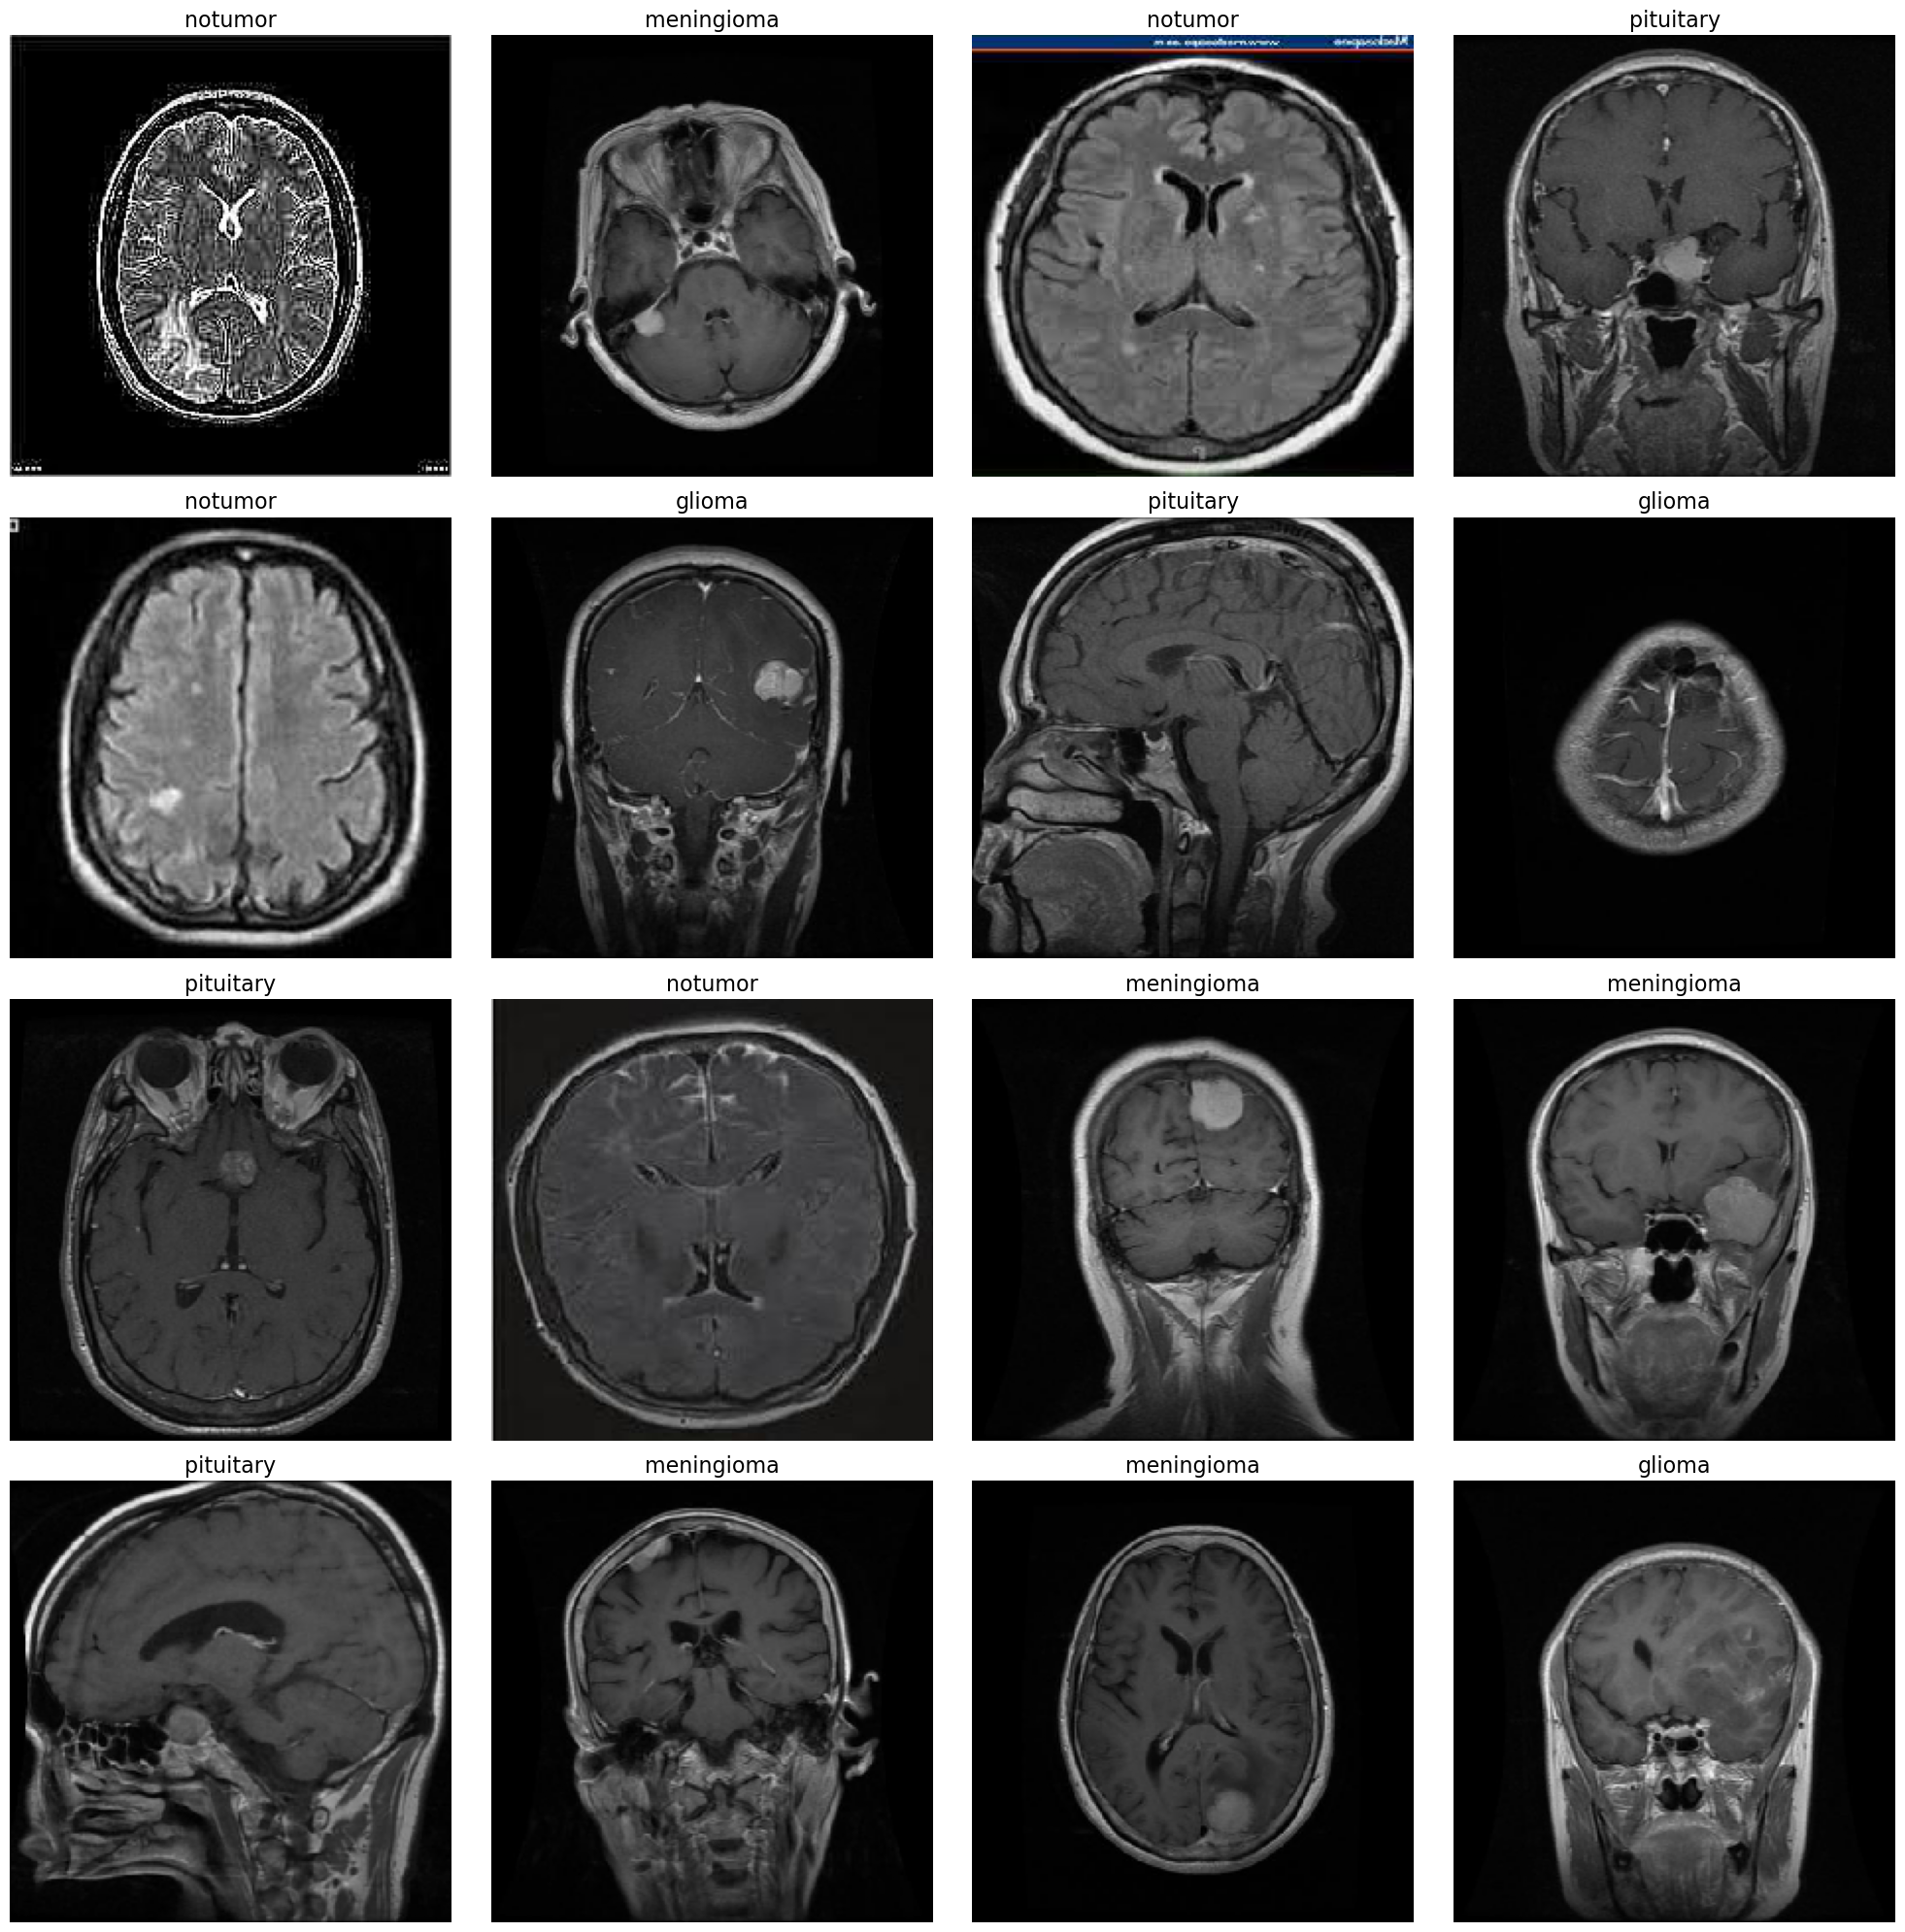

In [14]:
# Visualizing images from the training generator
def visualize_training_images(train_gen, classes=None, batch_size=16):
    if classes is None:
        g_dict = train_gen.class_indices #dictionary: {class: index}
        classes = list(g_dict.keys()) #list of dictionary keys: classes
    images, labels = next(train_gen) #get batch sample from generator
    
    plt.figure(figsize=(20, 20))
    for i in range(min(batch_size, len(images))):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255  # Scales data to range (0 - 1)
        plt.imshow(image)
        index = np.argmax(labels[i])  # image index
        class_name = classes[index]  # classification of image
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#use of generator and view batch: 
train_gen, valid_gen, test_gen = create_generators(train_df, true_df, test_df)
visualize_training_images(train_gen)

<h2>Creating and Adjusting the Sequential Model</h2>

In [25]:
# Model Configuration
channels = 3 # Amount of color channels in each image (RGB)
image_size = (224, 224) # Images are resized to these dimensions (#, #) pixels
image_shape = (image_size[0], image_size[1], channels)
class_count = len(train_gen.class_indices)  # Define number of classes for the output layer

# Initialize Sequential Model
model = Sequential()

# Explicit Input Layer for defining the input shape of the model
model.add(Input(shape=image_shape))

# Parameters for convolutional blocks
filter_blk1 = 32
filter_blk2 = 64
padding = 'same' # Padding strategy - 'same' ensures output feature maps have the same dimensions as the input.
activation = 'relu' # ReLU used for efficiency
kernel_size = (3, 3)

# Convolutional Block 1
model.add(Conv2D(filters=filter_blk1, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(MaxPooling2D(pool_size=(2, 2))) # Reduces spatial dimensions of the output from first layer

# Convolutional Block 2
model.add(Conv2D(filters=filter_blk2, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# Flatten the 2D output from previous layers to a 1D vector to feed into the dense layers.
model.add(Flatten())

# Dense Layers (Fully Connected Layers)
model.add(Dense(64, activation=activation))
model.add(Dense(32, activation=activation))

# Output Layer
model.add(Dense(class_count, activation='softmax'))

# Model Summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,866,724 (49.08 MB)

 Trainable params: 12,866,724 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

<h2>Training the CNN Model</h2>

In [29]:
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

# Number of times the training process will work through the entire dataset
# Lower number in the case there are performnance issues
epochs = 20

information = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= True)

Epoch 1/20


C:\Users\oorti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 50s 136ms/step - accuracy: 0.6946 - loss: 26.7642 - val_accuracy: 0.8733 - val_loss: 0.4111
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.9480 - loss: 0.1796 - val_accuracy: 0.9344 - val_loss: 0.2106
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.9733 - loss: 0.0842 - val_accuracy: 0.9450 - val_loss: 0.1828
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.9888 - loss: 0.0453 - val_accuracy: 0.9435 - val_loss: 0.2222
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.9897 - loss: 0.0401 - val_accuracy: 0.9435 - val_loss: 0.2256
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.9909 - loss: 0.0341 - val_accuracy: 0.9405 - val_loss: 0.2477
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9835 - loss: 0.0812 - val_accuracy: 0.9527 - val_loss: 0.1779
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.9950 - loss: 0.0209 - val_accur

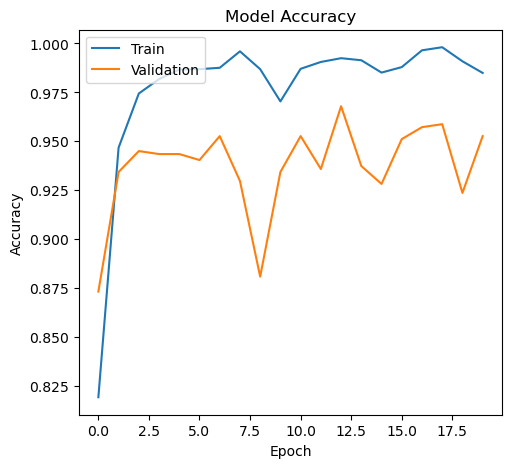

In [31]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(information.history['accuracy'], label='Train')
plt.plot(information.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

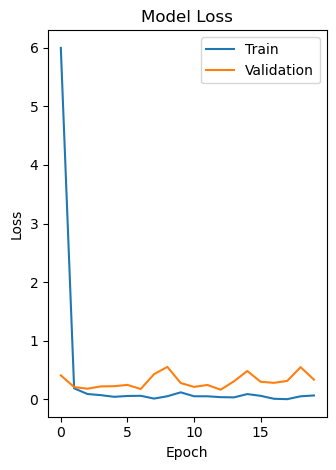

In [33]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(information.history['loss'], label='Train')
plt.plot(information.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Model Evaluation

In [ ]:
trainingScore = model.evaluate(train_gen, verbose =1 )#verbosity set to 1
validScore = model.evaluate(valid_gen, verbose =1)
testingScore = model.evaluate(test_gen, verbose =1)

print(f"Train loss : {trainingScore[0]}\n Train Accuracy: {trainingScore[1]}")
print("-"*40)
print(f"Valid Loss: {validScore[0]} \nValid Accuracy: {validScore[1]}")
print("-"*40)
print(f"Test loss: {testingScore[0]}\n Test Accuracy: {testingScore[1]}")

# Attaining Predictions

In [ ]:
preds = model.predict(test_gen)
#print(preds) #testing
y_preds = np.argmax(preds, axis = 1) #getting the maximum from predictions (axis = 1: rows)

# Creating Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
tempDict = test_gen.class_indices
classes = list(tempDict.keys())  # only get keys for classification

confMatrix = confusion_matrix(test_gen.classes, y_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(confMatrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = confMatrix.max() / 2.
for i, j in itertools.product(range(confMatrix.shape[0]), range(confMatrix.shape[1])):
    plt.text(j, i, confMatrix[i, j],
             horizontalalignment='center',
             color='white' if confMatrix[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Class Report


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_preds, target_names=classes))